### Importing Libraries

In [1]:
import os
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Spark Configuration

In [2]:
conf = pyspark.SparkConf()

conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','8g')
sc = pyspark.SparkContext(conf=conf)

spark = pyspark.SQLContext.getOrCreate(sc)
from pyspark.sql.functions import *

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/07 21:56:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/envs/bigdata/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Importing Data

In [3]:
df = spark\
.read\
.option("inferSchema","true")\
.option("header", "true")\
.csv("ratings.csv")

In [6]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [7]:
df.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    307|   3.5|1256677221|
|     1|    481|   3.5|1256677456|
|     1|   1091|   1.5|1256677471|
|     1|   1257|   4.5|1256677460|
|     1|   1449|   4.5|1256677264|
+------+-------+------+----------+
only showing top 5 rows



### Dropping TimeStamp Column

In [8]:
df=df.drop('timestamp')
df.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|    307|   3.5|
|     1|    481|   3.5|
|     1|   1091|   1.5|
|     1|   1257|   4.5|
|     1|   1449|   4.5|
+------+-------+------+
only showing top 5 rows



### Split Data into Train and Test

## Exploratory Data Analysis

### Number of Unique Movies

In [4]:
df.createOrReplaceTempView("df_movies")

In [5]:
q1=spark.sql(""" select count(distinct(movieId)) as Unique_Movies
             from df_movies """)
q1.show()

+-------------+
|Unique_Movies|
+-------------+
|        53885|
+-------------+



### Number of Unique Users

In [6]:
q2=spark.sql(""" select count(distinct(userId)) as Unique_Users
             from df_movies """)
q2.show()

+------------+
|Unique_Users|
+------------+
|      282472|
+------------+



### Ratings Distribution

(array([ 441017.,  883945.,  440537., 1846607., 1370896., 5502982.,
        3397246., 7376251., 2367834., 4060873.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

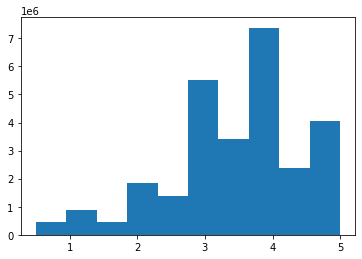

In [8]:
ratings=df.select('rating').rdd.flatMap(lambda x: x).collect()
plt.hist(ratings,10)

### Minimum and Maximum number of ratings given by an user

In [11]:
#Split the data into train and test set
train, test = df.randomSplit([0.8,0.2])

In [12]:
#GroupBy movie ratings to check for the number of users
user_count = train.groupBy('userId').count().toPandas()
print('Max User Count: {}'.format(user_count['count'].max()))
print('Min User Count: {}'.format(user_count['count'].min()))

Max User Count: 18915
Min User Count: 1


In [13]:
#GroupBy user ratings each movie has
movie_count = train.groupBy('movieId').count().toPandas()
print('Max Movie Count: {}'.format(movie_count['count'].max()))
print('Min Movie Count: {}'.format(movie_count['count'].min()))

Max Movie Count: 78458
Min Movie Count: 1


### Training our Model

In [14]:
#Training the ALS model
from pyspark.ml.recommendation import ALS

als_model = ALS(userCol='userId',
                itemCol='movieId',
                nonnegative=True,
                regParam=0.1,
                rank=10)
# rank is the number of latent factors we are choosing

recommender = als_model.fit(train)

In [15]:
predictions = recommender.transform(test)

In [16]:
predictions.describe().show()

+-------+-----------------+------------------+------------------+--------------------+-----------+
|summary|           userId|           movieId|            rating|           timestamp| prediction|
+-------+-----------------+------------------+------------------+--------------------+-----------+
|  count|          5537440|           5537440|           5537440|             5537440|    5537440|
|   mean|141587.1346490436| 18484.90387652056| 3.531124581033835|1.1932480093971403E9|        NaN|
| stddev|81546.48005935358|35099.583738744404|1.0662115171060889| 2.160148494700496E8|        NaN|
|    min|                1|                 1|               0.5|           789652009|0.024595661|
|    max|           282472|            193882|               5.0|          1537945078|        NaN|
+-------+-----------------+------------------+------------------+--------------------+-----------+



In [17]:
predictions.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [18]:
#drop Null values
predictions = predictions.na.drop()

### Calculating Error

In [19]:
predictions = predictions.withColumn("squared_error", (predictions.rating - predictions.prediction)**2)

In [20]:
predictions

userId,movieId,rating,timestamp,prediction,squared_error
1,1590,2.5,1256677236,2.4769917,5.293840113154147E-4
1,2478,4.0,1256677239,3.304869,0.48320719538884305
1,2840,3.0,1256677500,2.442903,0.3103570207915709
1,2986,2.5,1256677496,2.0847154,0.17246132693458094
1,3698,3.5,1256677243,3.008916,0.24116359210984228
3,828,4.0,945141610,2.6987247,1.6933172848403046
3,960,3.0,945141407,3.2846305,0.08101454261174013
5,318,5.0,1209040104,4.5814266,0.17520367403994896
5,1186,2.0,1209039308,3.7178175,2.9508971176938417
5,5954,4.0,1209039949,4.171159,0.029295331595676544


In [21]:
import pyspark.sql.functions as F
rmse = predictions.select(F.sqrt(F.avg(F.col('squared_error'))).alias('rmse'))

In [22]:
rmse

rmse
0.8238701777448263


### Violin Plot

In [23]:
predictions_df = predictions.toPandas()

/opt/conda/envs/bigdata/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/opt/conda/envs/bigdata/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


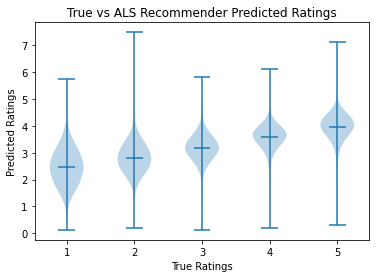

In [24]:
#Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1,6)]
plt.violinplot(data,range(1,6),showmeans=True)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs ALS Recommender Predicted Ratings')
plt.show()

### Movie and User Recommendation

In [25]:
#Generate top 10 movie recommendations for each user
userRecs = recommender.recommendForAllUsers(10)
#Generate top 10 user recommendations for each movie
movieRecs = recommender.recommendForAllItems(10)
userRecs_df = userRecs.toPandas()
movieRecs_df = movieRecs.toPandas()

/opt/conda/envs/bigdata/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [26]:
def get_movie_recommendations(user_id):
    return userRecs_df.loc[user_id].recommendations

In [27]:
get_movie_recommendations(1)

[Row(movieId=151989, rating=3.9811220169067383),
 Row(movieId=177209, rating=3.894380807876587),
 Row(movieId=179063, rating=3.877295732498169),
 Row(movieId=138580, rating=3.8146867752075195),
 Row(movieId=66389, rating=3.728227138519287),
 Row(movieId=159761, rating=3.72804856300354),
 Row(movieId=190707, rating=3.7265920639038086),
 Row(movieId=182493, rating=3.721248149871826),
 Row(movieId=169648, rating=3.7063305377960205),
 Row(movieId=117352, rating=3.6975557804107666)]

In [28]:
get_movie_recommendations(420)

[Row(movieId=193759, rating=5.44693660736084),
 Row(movieId=151989, rating=5.445700645446777),
 Row(movieId=138580, rating=5.225564956665039),
 Row(movieId=177209, rating=5.156368255615234),
 Row(movieId=185579, rating=5.060628890991211),
 Row(movieId=182155, rating=4.9324631690979),
 Row(movieId=176363, rating=4.915713310241699),
 Row(movieId=114070, rating=4.867107391357422),
 Row(movieId=173153, rating=4.7409467697143555),
 Row(movieId=192089, rating=4.7145676612854)]

In [29]:
def get_user_recommendations(movie_id):
    return movieRecs_df.loc[movie_id].recommendations

In [30]:
get_user_recommendations(1)

[Row(userId=268979, rating=5.014820098876953),
 Row(userId=236432, rating=4.995967864990234),
 Row(userId=213750, rating=4.972465515136719),
 Row(userId=196550, rating=4.94927978515625),
 Row(userId=2573, rating=4.937995910644531),
 Row(userId=118276, rating=4.930668830871582),
 Row(userId=11784, rating=4.929383277893066),
 Row(userId=100971, rating=4.9267048835754395),
 Row(userId=14051, rating=4.925989151000977),
 Row(userId=124021, rating=4.904113292694092)]

In [31]:
get_user_recommendations(420)

[Row(userId=174669, rating=5.700204849243164),
 Row(userId=189529, rating=5.546278953552246),
 Row(userId=66306, rating=5.466180324554443),
 Row(userId=139996, rating=5.403791427612305),
 Row(userId=85393, rating=5.34375524520874),
 Row(userId=141256, rating=5.302724361419678),
 Row(userId=955, rating=5.252330780029297),
 Row(userId=206407, rating=5.243793487548828),
 Row(userId=151445, rating=5.224103927612305),
 Row(userId=31381, rating=5.196128845214844)]